In [4]:
!hostname
!python -c "import jax; print(jax.default_backend())"
import jax; print(jax.__file__)
import jaxpm; print(jaxpm.__file__)
import numpyro; print(numpyro.__file__)
import haiku; print(haiku.__file__)
# import diffrax; print(diffrax.__file__)

feynmangpu04.cluster.local
gpu
/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib/python3.10/site-packages/jax/__init__.py
/feynman/home/dphp/hs276503/.local/lib/python3.10/site-packages/jaxpm/__init__.py
/feynman/home/dphp/hs276503/.local/lib/python3.10/site-packages/numpyro/__init__.py
/feynman/home/dphp/hs276503/.local/lib/python3.10/site-packages/haiku/__init__.py


In [2]:
!pip install diffrax

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for jax>=0.4.13 from https://files.pythonhosted.org/packages/e2/91/f79afe4818b08f5809e0125723e4c0adea65062f278a25847649b17ec6ea/jax-0.4.19-py3-none-any.whl.metadata
  Using cached jax-0.4.19-py3-none-any.whl.metadata (23 kB)
Using cached jax-0.4.19-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numpyro 0.13.2 requires jaxlib>=0.4.14, but you have jaxlib 0.4.2+cuda11.cudnn82 which is incompatible.


In [5]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

import matplotlib.pyplot as plt

import h5py
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u
import numpy as np
# from bpcosmo.pm import get_density_planes
from jaxpm.lensing import convergence_Born
import jax
import jax.numpy as jnp

import jax_cosmo as jc

import numpyro
import numpyro.distributions as dist

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn
from jaxpm.kernels import fftk
from jaxpm.lensing import density_plane
import haiku as hk

from jaxpm.painting import cic_paint, cic_read, cic_paint_2d
from jaxpm.kernels import gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import gaussian_smoothing, power_spectrum

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

import numpyro
import numpyro.distributions as dist

In [ ]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,
                                   source[f"bin_{i}"][:],
                                   bw=0.01, zmax=2.5) for i in range(4)]


# Loads some correction factors to improve the resolution of the simulation
import pickle
params = pickle.load( open( "camels_25_64_pkloss.params", "rb" ) )

model = hk.without_apply_rng(
    hk.transform(lambda x, a: NeuralSplineFourierFilter(n_knots=16,
                                                        latent_size=32)(x, a)))

## Initial conditions 

In [15]:
def linear_field(mesh_shape, box_size, pk):
  """
    Generate initial conditions.
    """
  kvec = fftk(mesh_shape)
  kmesh = sum((kk / box_size[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
    box_size[0] * box_size[1] * box_size[2])

  # field = numpyro.sample(
  #     'initial_conditions',
  #     dist.Normal(jnp.zeros(mesh_shape), jnp.ones(mesh_shape)))
  field = jax.random.normal(jax.random.PRNGKey(42), mesh_shape)

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field

In [37]:
box_length = 1000 # 100
mesh_length = 200 # 32
box_size = np.array([box_length, box_length, box_length])  # In Mpc/h
mesh_size = [mesh_length, mesh_length, mesh_length]
k_nyquist = 1/2 * jnp.min(mesh_size / box_size)
delta_k = jnp.min(1 / box_size)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

# Create a small function to generate the matter power spectrum
Omega_c, sigma8 = 0.25, 0.8
cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)
k = jnp.logspace(-4, 1, 256)
pk = jc.power.linear_matter_power(cosmology, k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# sample initial conditions and compute power spectrum
initial_conditions = linear_field(mesh_size, box_size, pk_fn)
pk_init_sim = power_spectrum(initial_conditions, kmin=0.0, dk=0.1, boxsize=box_size) 

2023-10-25 18:35:31.498933: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:789] failed to record completion event; therefore, failed to create inter-stream dependency
2023-10-25 18:35:31.499027: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1180] failed to enqueue async memcpy from host to device: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; GPU dst: 0x7ff580001700; host src: 0x7ffee6e00000; size: 12=0xc
2023-10-25 18:35:31.499053: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/stream.cc:336] Error recording event in stream: Error recording CUDA event: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; not marking stream as bad, as the Event object may be at fault. Monitor for further errors.
2023-10-25 18:35:31.499080: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:615] unable to add host callback: CU

ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.func.launch' failed: Failed to launch CUDA kernel: reduce_7 with block dimensions: 1x1x1 and grid dimensions: 1x1x1: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered.

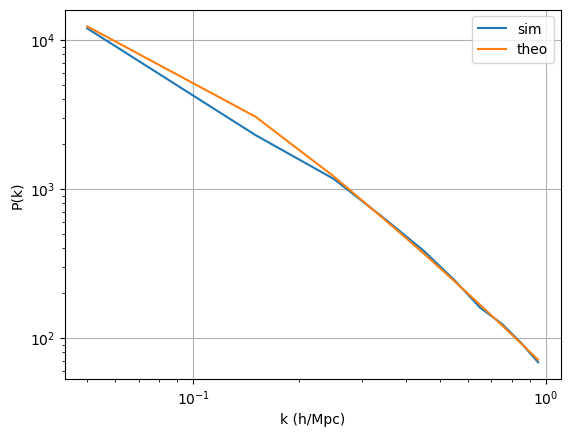

In [35]:
plt.loglog(pk_init_sim[0], pk_init_sim[1], label="sim")
plt.loglog(pk_init_sim[0], pk_fn(pk_init_sim[0]), label="theo")
plt.grid(), plt.legend(), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)");

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.random.rand(3,4,5)
xx, yy, zz = np.indices(data.shape)
col = data.flatten()

# 3D Plot
fig = plt.figure()
ax3D = fig.add_subplot(projection='3d')
cm = plt.colormaps['brg']
p3d = ax3D.scatter(xx, yy, zz, c=col, cmap=cm)
plt.colorbar(p3d)

plt.show()

## Inference